# Inverse Probability Weighting Model: IPW MODEL

IPW aims at computing the average effect estimation between several treatments.

First it computes the probability that each observation belongs to a group,
and use its inverse as the weight of that observation.

# IMPORTS

In [353]:
%matplotlib inline
import numpy as np 
import pandas as pd
from causallib.estimation import IPW
from causallib.evaluation import PropensityEvaluator
from causallib.datasets import load_nhefs
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from IPython.display import Image, display
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

We will work on the famous dataset from Hernan and Robins Causal Inference Book revolving around the effect of stopping cigarettes on weight losses.



In [354]:
population = load_nhefs()
population.X.join(population.a).join(population.y).head()

,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2,qsmk,wt82_71
0,42,1,0,30,29,79.04,0,0,0,0,0,0,0,1,1764,6247.3216,900,841,0,-10.093960
1,36,0,0,20,24,58.63,0,0,1,0,0,0,0,0,1296,3437.4769,400,576,0,2.604970
2,56,1,1,20,26,56.81,0,0,1,0,0,0,0,1,3136,3227.3761,400,676,0,9.414486
3,68,1,0,3,53,59.42,1,0,0,0,0,0,0,1,4624,3530.7364,9,2809,0,4.990117
4,40,0,0,20,19,87.09,1,0,1,0,0,0,1,0,1600,7584.6681,400,361,0,4.989251


# TRAINING AND PREDICTION OF THE WEIGHTS

We use a learner parameter that we will call model through the work for the causal model.
We will try to predict probability of quit smoking given the covariates through Machine Learning.
We will then use those probabilities to obtain our weights for each sample/observation.
Finally we will estimate the average balanced outcome between two treatments in the beginning using Horvitz –Thompson estimator.

In [355]:
# We train the model:
model = LogisticRegression(solver="liblinear")
ipw = IPW(model)
ipw.fit(population.X, population.a)

# Prediction weight of each individual:
ipw.compute_weights(population.X, population.a).head()

0    1.151658
1    1.202552
2    1.203629
3    1.927535
4    1.336785
dtype: float64

In [356]:
# Estimate average outcome
estimate_avg_outcomes = ipw.estimate_population_outcome(population.X, population.a, population.y)
estimate_avg_outcomes

0    1.749876
1    5.240249
dtype: float64

In [357]:
# Estimate the effect:
effect = ipw.estimate_effect(estimate_avg_outcomes[1], estimate_avg_outcomes[0])
effect

diff    3.490373
dtype: float64

In [358]:
model_2 = LogisticRegression(
    penalty="l1", 
    C=0.001, 
    max_iter=1000, 
    solver='liblinear'
    )

In [359]:
min_clip = 0.1
max_clip = 0.9
ipw = IPW(
    model_2, 
    clip_min=min_clip, 
    clip_max=max_clip, 
    use_stabilized=False
    )
ipw.fit(population.X, population.a)

IPW(clip_max=0.9, clip_min=0.1, use_stabilized=False, verbose=False,
    learner=LogisticRegression(C=0.001, max_iter=1000, penalty='l1', solver='liblinear'))

In [360]:
probs = ipw.compute_propensity(population.X, population.a, treatment_values=1)
probs.between(min_clip, max_clip).all()

True

In [361]:
probs = ipw.compute_propensity(population.X, population.a, treatment_values=1, clip_min=0.0, clip_max=1.0)
probs.between(min_clip, max_clip).all()

False

In [362]:
probabilities_weights = ipw.compute_weights(
    population.X, 
    population.a, 
    treatment_values=1, 
    clip_min=0.0, 
    clip_max=1.0, 
    use_stabilized=True
    )
weights = ipw.compute_weights(
    population.X, 
    population.a, 
    treatment_values=1, 
    clip_min=0.0, 
    clip_max=1.0
    )
probabilities_weights.eq(weights).all()

False

In [363]:
# Display the weight matrix based on the previous computations of probabilities weights.
ipw.compute_weight_matrix(population.X, population.a).head()

,0,1
0,1.303083,4.299430
1,1.395928,3.525712
2,1.469016,3.132125
3,1.604349,2.654672
4,1.348047,3.873178


In [364]:
# Display the weight matrix of probabilities
ipw.compute_propensity_matrix(population.X, population.a).head()

,0,1
0,0.767411,0.232589
1,0.716369,0.283631
2,0.680728,0.319272
3,0.623306,0.376694
4,0.741814,0.258186


In [365]:
outcomes = ipw.estimate_population_outcome(population.X, population.a, population.y, w=weights)
effects = ipw.estimate_effect(outcomes[1], outcomes[0], effect_types=["diff", "ratio"])
effects

diff     2.624926
ratio    2.255233
dtype: float64

In [366]:
prop_evaluator = PropensityEvaluator(ipw)
results = prop_evaluator.evaluate_simple(population.X, population.a, population.y)

In [367]:
results.scores.prediction_scores

,accuracy,precision,recall,f1,roc_auc,avg_precision,hinge,matthews,0/1,brier
0,0.742656,0.0,0.0,0.0,0.557793,0.303335,1.130276,0.0,0.257344,0.1902


In [368]:
results.scores.covariate_balance.head()

abs_smd,weighted,unweighted
covariate,,
age,0.142042,0.199560
race,0.149865,0.125194
sex,0.177504,0.113323
smokeintensity,0.024769,0.153345
smokeyrs,0.079561,0.112470


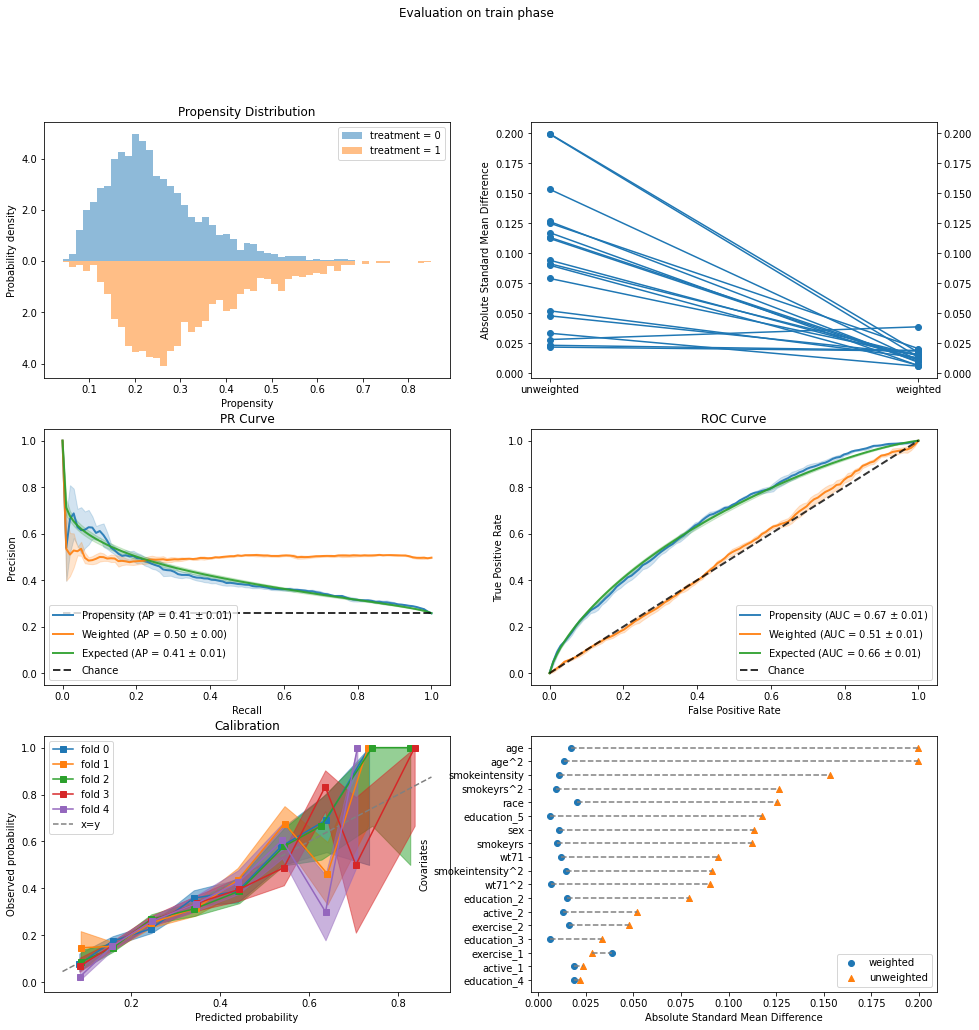

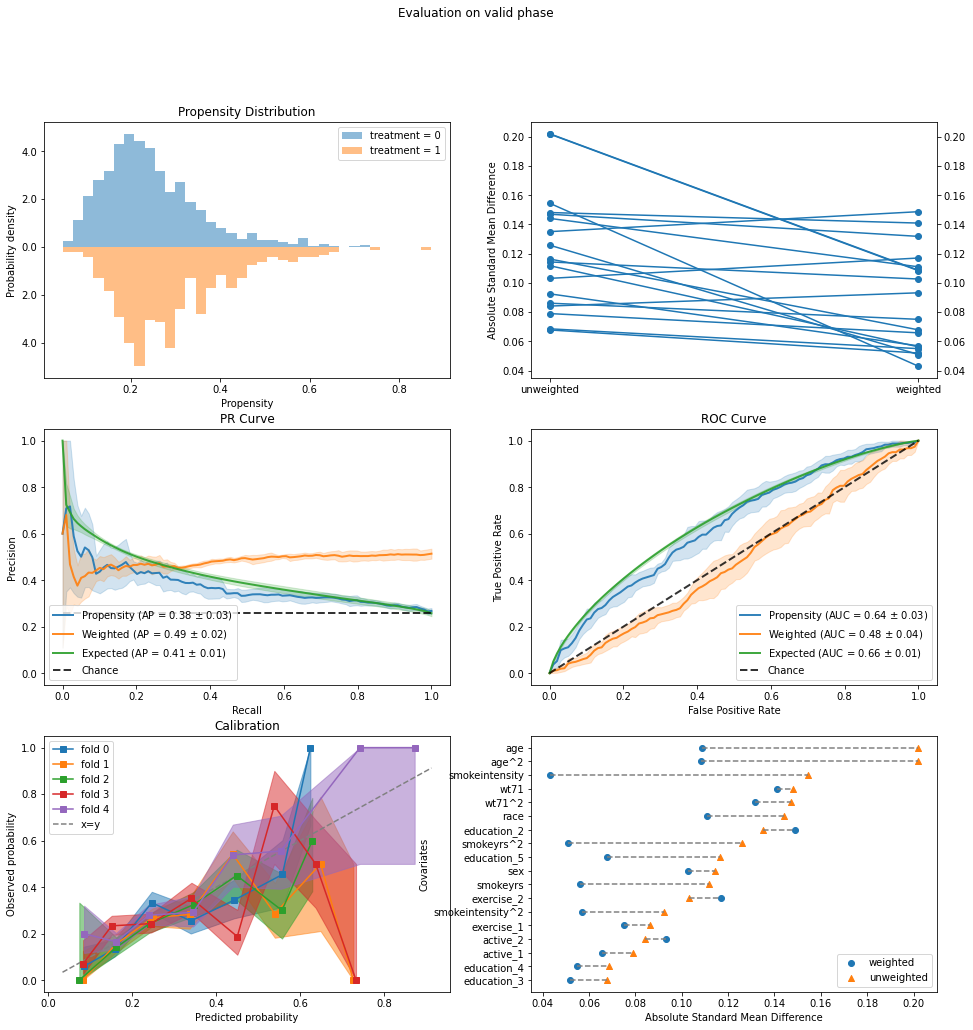

In [369]:
plots=[
       "weight_distribution",
       "covariate_balance_slope",
       "pr_curve",
       "roc_curve", 
       "calibration", 
       "covariate_balance_love"
       ]

metrics = {"roc_auc": metrics.roc_auc_score,
           "avg_precision": metrics.average_precision_score}

ipw = IPW(LogisticRegression(solver="liblinear"))

prop_evaluator = PropensityEvaluator(ipw)
results = prop_evaluator.evaluate_cv(
    population.X, 
    population.a, 
    population.y, 
    metrics_to_evaluate=metrics,
    plots=plots
    )

In [370]:
results.scores.prediction_scores

roc_auc  avg_precision
phase fold                           
train 0    0  0.662579       0.410807
      1    0  0.662319       0.412369
      2    0  0.662429       0.411065
      3    0  0.677559       0.430324
      4    0  0.666998       0.395738
valid 0    0  0.653314       0.401839
      1    0  0.651717       0.354418
      2    0  0.663144       0.401750
      3    0  0.591369       0.329489
      4    0  0.621967       0.414739

# Estimating effect of multiple treatments

In [371]:
# The model
NUM_SAMPLES = 10000
NUM_TREATMENTS = 3

dataset = dowhy.datasets.linear_dataset(
    10, 
    num_common_causes=10, 
    num_samples=NUM_SAMPLES,
    num_instruments=0, 
    num_effect_modifiers=2,
    num_treatments=NUM_TREATMENTS,
    treatment_is_binary=False,
    num_discrete_common_causes=3,
    num_discrete_effect_modifiers=0,
    one_hot_encode=False
    )
dataframe=dataset['df']
dataframe.head()

,X0,X1,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,v0,v1,v2,y
0,-0.425751,-1.403270,0.282368,-0.107157,0.687852,1.846834,0.364248,0.132948,1.362900,0,0,2,14.992290,17.450888,13.999366,-10139.450154
1,-0.544001,-1.051135,-0.385695,0.633018,1.613009,0.503761,-0.022545,-1.435277,-0.036672,1,2,3,20.345825,23.914674,21.451022,-33288.929449
2,1.119134,-0.327210,0.842567,0.289953,1.619116,-0.027494,1.749365,2.689852,0.721240,2,2,1,20.091343,28.663734,33.258275,100129.878757
3,0.406410,-0.828044,1.122880,0.164428,-1.316789,-0.656826,-0.824928,1.682418,-0.167671,3,1,3,5.536876,33.120135,27.494335,7998.383769
4,-2.913716,-0.064697,1.585520,0.830686,0.186978,0.193320,-0.796935,-0.656710,-0.903178,0,0,2,5.885638,11.768069,7.836266,-7374.994829


In [372]:
model = CausalModel(
    data=dataset["df"],
    treatment=dataset["treatment_name"], 
    outcome=dataset["outcome_name"],
    graph=dataset["gml_graph"]
    )

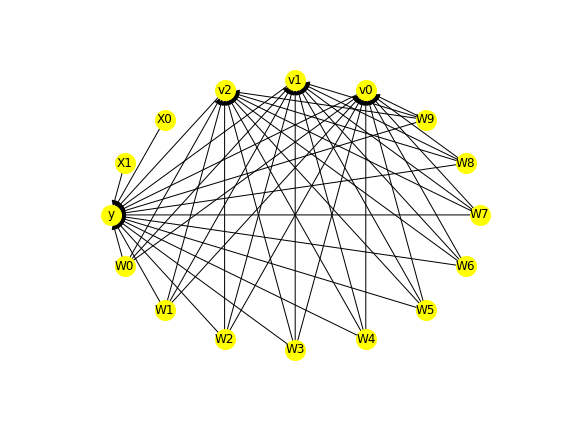

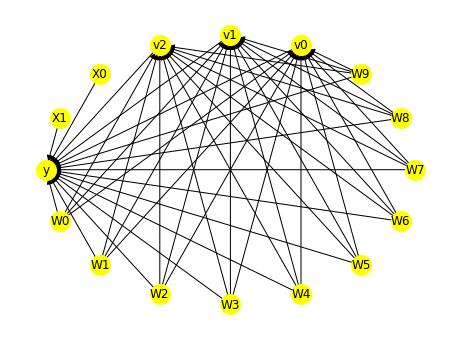

In [373]:
model.view_model()
display(Image(filename="causal_model.png"))

In [374]:
chosen_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(chosen_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                    
─────────────(Expectation(y|W1,W9,W8,W6,W5,W7,W2,W3,W0,W4))
d[v₀  v₁  v₂]                                              
Estimand assumption 1, Unconfoundedness: If U→{v0,v1,v2} and U→y then P(y|v0,v1,v2,W1,W9,W8,W6,W5,W7,W2,W3,W0,W4,U) = P(y|v0,v1,v2,W1,W9,W8,W6,W5,W7,W2,W3,W0,W4)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# Linear model
The control values and treatment values are represented as a list/tuple because we are now working on a multi-dimensional the treatment.

We interpret the change in y when (v0, v1, v2) are changed from (0,0,0) to (1,1,1).

In [375]:
linear_estimation = model.estimate_effect(
    chosen_estimand,
     method_name="backdoor.linear_regression",
     control_value=(0,0,0),
     treatment_value=(1,1,1),
     method_params={'need_conditional_estimates': False})

print(linear_estimation)

linear_regression
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                    
─────────────(Expectation(y|W1,W9,W8,W6,W5,W7,W2,W3,W0,W4))
d[v₀  v₁  v₂]                                              
Estimand assumption 1, Unconfoundedness: If U→{v0,v1,v2} and U→y then P(y|v0,v1,v2,W1,W9,W8,W6,W5,W7,W2,W3,W0,W4,U) = P(y|v0,v1,v2,W1,W9,W8,W6,W5,W7,W2,W3,W0,W4)

## Realized estimand
b: y~v0+v1+v2+W1+W9+W8+W6+W5+W7+W2+W3+W0+W4+v0*X0+v0*X1+v1*X0+v1*X1+v2*X0+v2*X1
Target units: ate

## Estimate
Mean value: -2918.440328839173



We can estimate the conditional effects computed by the effect modifiers.



In [376]:
linear_estimation = model.estimate_effect(
    chosen_estimand,
    method_name="backdoor.linear_regression",
    control_value=(0,0,0),
    treatment_value=(1,1,1))
print(linear_estimation)

linear_regression
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                    
─────────────(Expectation(y|W1,W9,W8,W6,W5,W7,W2,W3,W0,W4))
d[v₀  v₁  v₂]                                              
Estimand assumption 1, Unconfoundedness: If U→{v0,v1,v2} and U→y then P(y|v0,v1,v2,W1,W9,W8,W6,W5,W7,W2,W3,W0,W4,U) = P(y|v0,v1,v2,W1,W9,W8,W6,W5,W7,W2,W3,W0,W4)

## Realized estimand
b: y~v0+v1+v2+W1+W9+W8+W6+W5+W7+W2+W3+W0+W4+v0*X0+v0*X1+v1*X0+v1*X1+v2*X0+v2*X1
Target units: ate

## Estimate
Mean value: -2918.440328839173
### Conditional Estimates
__categorical__X0             __categorical__X1           
(-4.473000000000001, -1.497]  (-4.997000000000001, -1.599]   -7680.863131
                              (-1.599, -1.029]               -7522.720149
                              (-1.029, -0.51]                -7170.440379
                         